#Ensemble Learning and Random Forests

## Voting Classifiers

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators = [
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

*Pierwotne estymatory są dostępne w atrybucie `estimators`, podczas gdy dopasowane klony są dostępne w atrybucie `estimators_`. Jeśli wolisz używać słownika, a nie listy, możesz skorzystać z atrybutów `named_estimators` lub `named_estimators_`.*

In [5]:
voting_clf.estimators

[('lr', LogisticRegression(random_state=42)),
 ('rf', RandomForestClassifier(random_state=42)),
 ('svc', SVC(random_state=42))]

In [7]:
voting_clf.named_estimators_.items()

dict_items([('lr', LogisticRegression(random_state=42)), ('rf', RandomForestClassifier(random_state=42)), ('svc', SVC(random_state=42))])

In [8]:
for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


### hard voting

*Podczas wywoływania metody predict() klasyfikatora jest przeprowadzane twarde głosowanie. Na przykład klasyfikator głosujący przewiduje klasę 1. dla pierwszego przykładu ze zbioru testowego, ponieważ dwa z trzech klasyfikatorów przewidują tę klasę.*

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.predict(X_test[:1])

array([1])

In [12]:
voting_clf.score(X_test, y_test)

# Klasyfikator głosujący osiąga lepsze wyniki od jego elementów składowych (0.912)

0.912

### soft voting

*Jeżeli wszystkie klasyfikatory są w stanie przewidywać prawdopodobieństwo przynależności do klasy (np. jeśli wszystkie one korzystają z metody `predict_proba()`), to możemy sprawić, że moduł Scikit-Learn
będzie przewidywał klasę o największym prawdopodobieństwie poprzez uśrednienie wyników uzyskanych z poszczególnych klasyfikatorów. Jest to tak zwane **głosowanie miękkie (ang. soft voting)**. Często uzyskujemy za jego pomocą lepszą wydajność niż w przypadku głosowania większościowego, ponieważ
głosy o większej pewności mają nadawaną wyższą wagę. Wystarczy w hiperparametrze voting klasyfikatora głosującego wstawić wartość `"soft"` i upewnić się, że wszystkie klasyfikatory są w stanie szacować prawdopodobieństwo przynależności do klasy. Wyjątek stanowi klasa SVC, w której należy
wyznaczyć wartość `True` hiperparametru `probability` (zacznie być wtedy używany sprawdzian krzyżowy do szacowania prawdopodobieństwa, co spowolni cały proces uczenia, oraz zostanie dodana metoda `predict_proba()`).*

In [13]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

##Bagging and Pasting

*Innym rozwiązaniem jest trenowanie każdego predyktora za pomocą
tego samego algorytmu, ale przy użyciu różnych, losowych podzbiorów zbioru uczącego.*

* *Gdy próbkowanie jest przeprowadzane **ze zwracaniem (ang. sampling with replacement)**, mechanizm ten jest nazywany **agregacją (ang. bagging; nazwa jest skrótem angielskiego pojęcia bootstrap aggregating, czyli agregacja przykładów wstępnych)** - wyobraź sobie losowanie karty z talii, zapisanie jej na kartce, a następnie wtasowanie jej z powrotem do talii przed
kolejnym losowaniem: ta sama karta może być wielokrotnie losowana.*
* *Z kolei jeśli próbkowanie jest przeprowadzane **bez zwracania (ang. sampling without replacement)**, to mamy do czynienia z **wklejaniem**.*

##BaggingClassifier

*A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.*

* *When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as **Pasting**.*
* *If samples are drawn with replacement, then the method is known as **Bagging**.*
* *When random subsets of the dataset are drawn as random subsets of the features, then the method is known as **Random Subspaces**.*
* *Finally, when base estimators are built on subsets of both samples and features, then the method is known as **Random Patches**.*

### OOB
*W przypadku agregacji część przykładów uczących może być kilkakrotnie przypisywana jednemu predyktorowi, natomiast niektóre próbki mogą nie być wcale wykorzystane. **Domyślnie klasa BaggingClassifier próbkuje m przykładów uczących ze zwracaniem (bootstrap=True)**, gdzie m oznacza rozmiar zbioru uczącego. W przypadku tego procesu można dowieść matematycznie, że średnio zaledwie ok. 63% danych uczących jest próbkowanych dla każdego predyktora. Pozostałe 37% niewykorzystanych próbek nosi nazwę **przykładów pozatreningowych (ang. out-of-bag instances — OOB)**. Pamiętaj, że na te 37% przykładów pozatreningowych może składać się inny zbiór przykładów dla każdego predyktora.*

**Kiedy stosować BaggingClassifier (i jego warianty)?**

✅ **Modele o wysokiej wariancji:**

Bagging najlepiej sprawdza się dla niestabilnych algorytmów uczących się, czyli takich, które mocno reagują na drobne zmiany w danych treningowych.
Przykłady:
* Drzewa decyzyjne (zwłaszcza głębokie, nieregularyzowane)
* KNN (dla małych zbiorów danych)


✅ **Chęć poprawy ogólnej dokładności modelu:**

Jeśli pojedynczy model ma problemy z nadmiernym dopasowaniem (overfitting), Bagging może go ustabilizować i poprawić jego działanie na danych testowych.


✅ **Duży zbiór danych:**

Bagging wymaga wielokrotnego trenowania modeli, więc lepiej sprawdza się na większych zbiorach danych, gdzie różne próby dają istotnie różne podzbiory.


---
Porównanie technik Baggingowych

|Technika|	Jak działa?|	Kiedy stosować?|
|---|---|---|
|Pasting|	Losuje próbki bez zwracania|	Gdy mamy duży zbiór danych, chcemy niezależnych podzbiorów.|
|Bagging|	Losuje próbki ze zwracaniem (bootstrap)|	Standardowa metoda dla redukcji wariancji.|
|Random Subspaces|	Wybiera losowe podzbiory cech przy trenowaniu każdego modelu|	Przy wysokowymiarowych danych, gdy chcemy zwiększyć różnorodność modeli.|
|Random Patches|	Losuje zarówno próbki jak i cechy (łączy Bagging i Subspaces)|	Gdy chcemy maksymalnie zwiększyć różnorodność, np. dla obrazów, sygnałów itp.|

-

🟢 Stosuj BaggingClassifier, gdy:
* Twój podstawowy model ma wysoką wariancję.
* Twój zbiór danych zawiera sporo szumu.
* Masz wystarczające zasoby obliczeniowe, by trenować wiele modeli.



In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

base_clf = DecisionTreeClassifier(random_state=42)


# --- Bagging (bootstrap próbek)
bagging = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,
    random_state=42
)

# --- Pasting (bez zwracania próbek)
pasting = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    max_samples=0.8,
    bootstrap=False,
    random_state=42
)


# --- Random Subspaces (losowe cechy, bez zwracania próbek)
subspaces = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    max_features=0.5,
    bootstrap=False,
    bootstrap_features=True,
    random_state=42
)


# --- Random Patches (losowe próbki i cechy)
patches = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.5,
    bootstrap=True,
    bootstrap_features=True,
    random_state=42
)


models = {
    "Bagging": bagging,
    "Pasting": pasting,
    "Random Subspaces": subspaces,
    "Random Patches": patches
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:20s} Accuracy: {acc:.4f}")


Bagging              Accuracy: 0.9580
Pasting              Accuracy: 0.9371
Random Subspaces     Accuracy: 0.9510
Random Patches       Accuracy: 0.9510


### Porównanie stabilności poprzez wielokrotne losowa podziały zbiru danych

In [11]:
results = {name: [] for name in models}

# 30 losowych podziałów
for seed in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)
    for name, model in models.items():
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        results[name].append(acc)

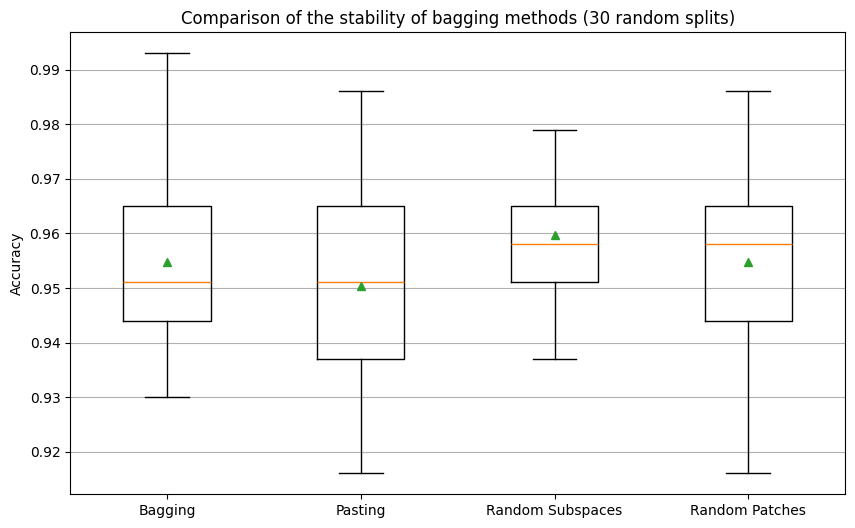

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([results[name] for name in models], tick_labels=models.keys(), showmeans=True)
plt.title("Comparison of the stability of bagging methods (30 random splits)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

## Random Forests

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

accuracy, precision, recall, f1

(0.965034965034965, 0.9775280898876404, 0.9666666666666667, 0.9720670391061452)

In [17]:
# A Random Forest is equivalent to a bag of decision trees:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

accuracy, precision, recall, f1

(0.965034965034965, 0.9775280898876404, 0.9666666666666667, 0.9720670391061452)

In [15]:
rnd_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}